<a href="https://colab.research.google.com/github/CJReese01/Homework/blob/master/PlantIdentification_MobileNet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***This is the script which houses the necessary code for transfer training with MobileNet_v2***<br>
*Transfer Model definitions at the bottom because they're intended to only be ran once*

# **Mounting the Drive/Loading in the Libraries**

In [ ]:
%load_ext tensorboard
import datetime
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from tqdm import tqdm # viewing progress of loops
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pickle
import random
import math
%matplotlib inline

# loading in the data
from google.colab import drive
drive.mount('/content/drive')
DATADIR = "/content/drive/MyDrive/CE315_Fall_2021/PlantImages"

Mounted at /content/drive


**Data Access Testing**

 Basswood	     Pickle	 treeFeature224x3Test.pickle
'Blue Spruce'	     Pinyon	 treeType224x3Test.pickle
'Engelmann Spruce'   Ponderosa
 Juniper	     Test


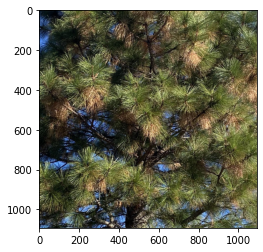

In [ ]:
!ls /content/drive/MyDrive/CE315_Fall_2021/PlantImages # Check contents of directory

img_array = cv2.imread("/content/drive/MyDrive/CE315_Fall_2021/PlantImages/Ponderosa/Ponderosa Full Tree/2021_10_25_09_28_IMG_0212.JPG")
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # Read img from folder and color correct

random.seed(345)
IMG_SIZE = 224
x = random.randrange(int(img_array.shape[1]/4),int(img_array.shape[1]/4*3))
y = random.randrange(int(img_array.shape[0]/4),int(img_array.shape[0]/4*3))
size = random.randrange(min(int(img_array.shape[1]/4),int(img_array.shape[0]/4)),min(int(img_array.shape[1]/4*3),int(img_array.shape[0]/4*3)))
cropped_img = img_array[x:x+size,y:y+size]

plt.imshow(cropped_img)


# **Pickles**

224 x 3 - Compatible with MobileNet_V2 

In [ ]:
# Readily compatible with MobileNet_V2 part 1 
pickle_in = open("/content/drive/MyDrive/CE315_Fall_2021/PlantImages/Pickle/treeFeature224x3_0.pickle","rb")
treeFeature = pickle.load(pickle_in)
treeFeature.shape

pickle_in = open("/content/drive/MyDrive/CE315_Fall_2021/PlantImages/Pickle/treeType224x3_0.pickle","rb")
treeType = pickle.load(pickle_in)
treeType.shape

(21364,)

In [ ]:
# Readily compatible with MobileNet_V2 part 2 this one
pickle_in = open("/content/drive/MyDrive/CE315_Fall_2021/PlantImages/Pickle/treeFeature224x3_1.pickle","rb")
treeFeature = pickle.load(pickle_in)
treeFeature.shape

pickle_in = open("/content/drive/MyDrive/CE315_Fall_2021/PlantImages/Pickle/treeType224x3_1.pickle","rb")
treeType = pickle.load(pickle_in)
treeType.shape

(21364,)

Pickle Needed For Confusion Matrix

In [ ]:
pickle_in = open("/content/drive/MyDrive/CE315_Fall_2021/PlantImages/treeFeature224x3Test.pickle","rb")
treeFeatureTest = pickle.load(pickle_in)
treeFeatureTest.shape

pickle_in = open("/content/drive/MyDrive/CE315_Fall_2021/PlantImages/treeType224x3Test.pickle","rb")
treeTypeTest = pickle.load(pickle_in)
treeTypeTest.shape

(126,)

# **Load and Train MobileNet_V2 SGD Optimization**

In [ ]:
## Continued training of MobileNetV2 model
loadModel = tf.keras.models.load_model( ## Loading the model
    '/content/drive/MyDrive/CE315_Fall_2021/Models/MobileNetV2_SGD_Trees_2021Updated1.model')

oldModel = hub.KerasLayer(
    loadModel, input_shape=(224, 224, 3), trainable = True)
model = Sequential([oldModel])

opt = SGD(learning_rate = 0.001) # Setting optimizer as SGD and defining custom learning rate
model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

log_dir = "/content/drive/MyDrive/CE315_Fall_2021/logs/finalFit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit( ## Training the model
    treeFeature, treeType, batch_size = 32, epochs = 25, validation_split = 0.3, callbacks=[tensorboard_callback])

model.save( ## Saving the model
    '/content/drive/MyDrive/CE315_Fall_2021/Models/MobileNetV2_SGD_Trees_2021Updated2.model')


Got `type(handle)`: <class 'keras.engine.sequential.Sequential'>
Epoch 1/25
468/468 [==============================] - 100s 179ms/step - loss: 0.2289 - accuracy: 0.9520 - val_loss: 0.1877 - val_accuracy: 0.9672
Epoch 2/25
468/468 [==============================] - 82s 176ms/step - loss: 0.2013 - accuracy: 0.9608 - val_loss: 0.1862 - val_accuracy: 0.9685
Epoch 3/25
468/468 [==============================] - 80s 171ms/step - loss: 0.1816 - accuracy: 0.9660 - val_loss: 0.1805 - val_accuracy: 0.9682
Epoch 4/25
468/468 [==============================] - 81s 172ms/step - loss: 0.1683 - accuracy: 0.9722 - val_loss: 0.1790 - val_accuracy: 0.9702
Epoch 5/25
468/468 [==============================] - 80s 170ms/step - loss: 0.1593 - accuracy: 0.9756 - val_loss: 0.1754 - val_accuracy: 0.9716
Epoch 6/25
468/468 [==============================] - 82s 175ms/step - loss: 0.1491 - accuracy: 0.9795 - val_loss: 0.1752 - val_accuracy: 0.9693
Epoch 7/25
468/468 [==============================] - 82s 175ms

# Confusion Matrix 

In [ ]:
model = tf.keras.models.load_model( ## loading the model
    '/content/drive/MyDrive/CE315_Fall_2021/Models/MobileNetV2_SGD_Trees_2021Updated2.model')

Inorder to Run the Confusion maxtrix you need to load in the most recent .model file and the test Pickle which is in the pickle section and then just run the following portions of code

In [ ]:
# Class for the Creation of the Confusion Matrix 
# Pulled from the Internet
class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, num_classes, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(name='confusion_matrix_metric',**kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        """
        Make a confusion matrix
        """
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def process_confusion_matrix(self):
        "returns precision, recall and f1 along with overall accuracy"
        cm=self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return precision,recall,f1
    
    def fill_output(self,output):
        results=self.result()
        for i in range(self.num_classes):
            output['precision_{}'.format(i)]=results[0][i]
            output['recall_{}'.format(i)]=results[1][i]
            output['F1_{}'.format(i)]=results[2][i]
    


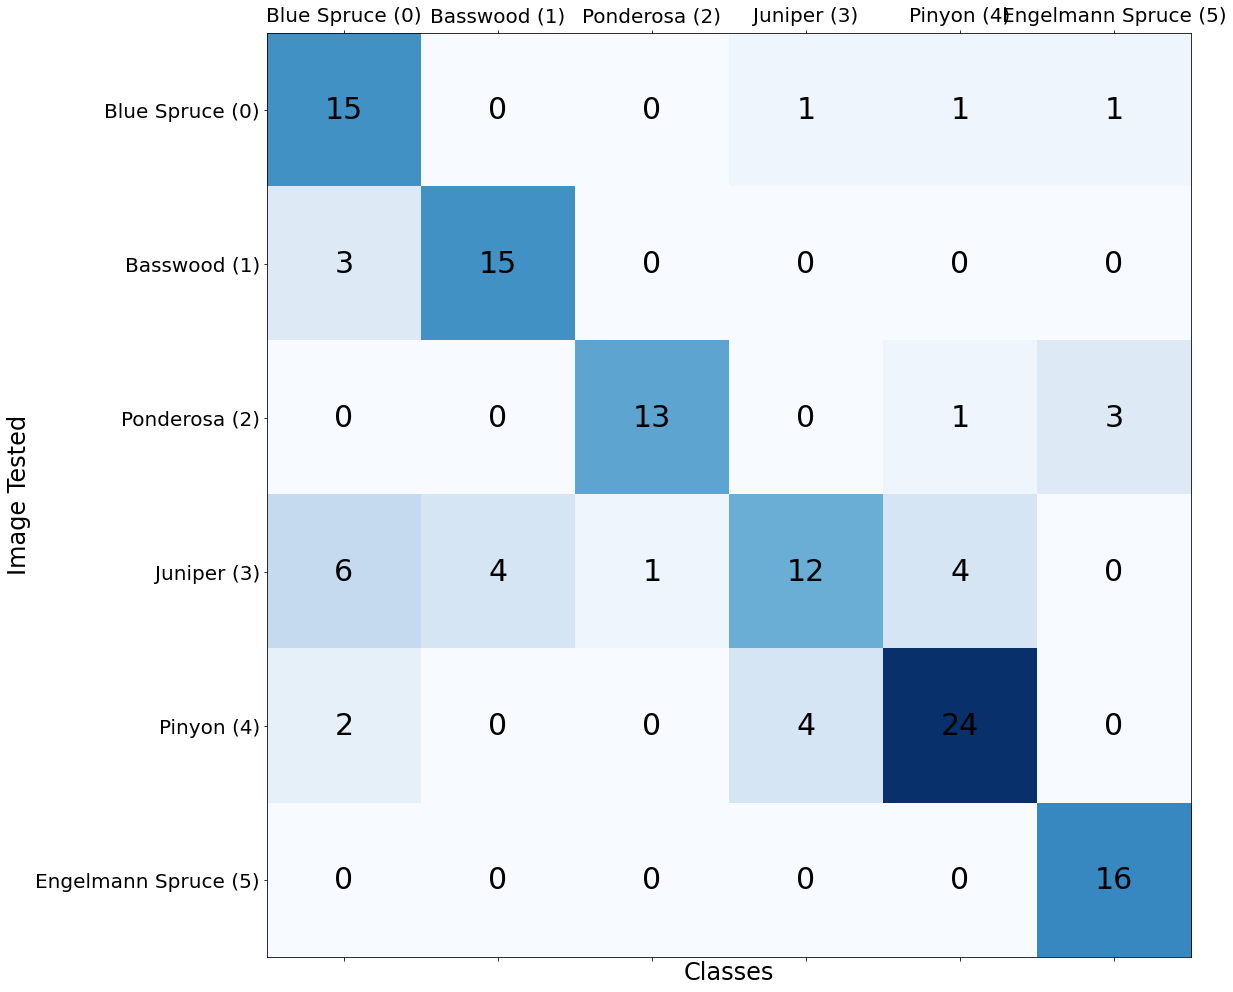

In [ ]:
lbls=dict(map(lambda x: x.split('\t'),"""0 	Blue Spruce
1 	Basswood
2 	Ponderosa
3 	Juniper
4 	Pinyon
5 	Engelmann Spruce""".split('\n')))
lbls={int(k):v for k,v in lbls.items()}

y_pred=model(treeFeatureTest)
y_pred_lbls=np.argmax(y_pred,-1)

cm=ConfusionMatrixMetric(6)
_=cm.update_state(treeTypeTest,y_pred)

fig, ax = plt.subplots(figsize=(17,17))


cm_matrix = cm.total_cm.numpy().astype(np.int32)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(6):
    for j in range(6):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center',fontsize=30)
plt.xlabel('Classes',fontsize = 24)
plt.ylabel('Image Tested', fontsize = 24)
plt.xticks(range(6),['{} ({})'.format(lbls[i],i) for i in range(6)],fontsize=20)
plt.yticks(range(6),['{} ({})'.format(lbls[i],i) for i in range(6)],fontsize=20)
plt.show()

# **Testing**

**Tensorboard**

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/CE315_Fall_2021/logs/finalFit

Launching TensorBoard...

KeyboardInterrupt: ignored

**Model Testing**

In [ ]:
total = 0
correct = 0
temp =0
for i in range(0,6):
  for j in range(0,6):
    total += cm_matrix[i][j]
    temp += cm_matrix[i][j]
  correct+=cm_matrix[i][i]
  print(cm_matrix[i][i]/(temp)*100)
  temp = 0

print("final",correct/(total)*100) #its 75.3% because juniper is so bad
print("Without Juniper", (correct-12)/(total-27)*100)

83.33333333333334
83.33333333333334
76.47058823529412
44.44444444444444
80.0
100.0
final 75.39682539682539
without juniper 83.83838383838383


In [ ]:
# Load the model you wish to test

##### MobileNet_V2
model = tf.keras.models.load_model( ## SGD Version
    '/content/drive/MyDrive/CE315_Fall_2021/Models/MobileNetV2_SGD_Trees_2021Updated2.model')

#model = tf.keras.models.load_model( ## ADAM Version
   #'/content/drive/MyDrive/CE315_Fall_2021/Models/MobileNetV2_ADAM_Trees_2021Updated.model')


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6)                 2265670   
                                                                 
Total params: 2,265,670
Trainable params: 2,231,558
Non-trainable params: 34,112
_________________________________________________________________


Prediction Value:  [[8.5330568e-04 5.0025978e-03 9.6972060e-01 2.2930125e-04 2.1624058e-02
  2.5700047e-03]]
Ponderosa


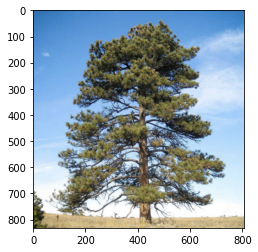

In [ ]:
# Test the model you selected

CATEGORIES = ["Blue Spruce", "Basswood", "Ponderosa","Juniper", "Pinyon","Engelmann Spruce"]
img = cv2.imread('/content/drive/MyDrive/image (1).png')

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

img = cv2.resize(img, (224,224))
img = img.reshape(-1,224,224,3)

predictions = model.predict([img])
print("Prediction Value: ", predictions)
for prediction in range(0,3):  
  if(int(np.round(predictions[0][prediction]))==1):
      print(CATEGORIES[prediction])


In [ ]:
CATEGORIES = ["Blue Spruce", "Basswood", "Ponderosa","Juniper", "Pinyon","Engelmann Spruce"]
predict = []

for imgname in os.listdir("/content/drive/MyDrive/CE315_Fall_2021/PlantImages/Test/Blue spruce/FullTree"):
  img = cv2.imread(os.path.join("/content/drive/MyDrive/CE315_Fall_2021/PlantImages/Test/Juniper/FullTree",imgname))
  img = cv2.resize(img, (224,224))
  img = img.reshape(-1,224,224,3)

  predictions = model.predict([img])
  print("Prediction Value: ", predictions)
  for prediction in range(0,6):  
    if(int(np.round(predictions[0][prediction]))==1):
        predict.append([CATEGORIES[prediction],predictions[0][prediction]])
        break
    elif(prediction == 5):
      predict.append(["unsure",predictions[0]])

Prediction Value:  [[0.08510881 0.7756029  0.06794829 0.02120966 0.03976107 0.01036934]]
Prediction Value:  [[4.4238605e-03 2.2295948e-02 3.5647778e-03 8.8366824e-01 8.5194506e-02
  8.5275469e-04]]
Prediction Value:  [[1.5310249e-04 3.4922264e-03 2.5166702e-03 9.9204552e-01 9.9998957e-04
  7.9244137e-04]]
Prediction Value:  [[1.2790271e-04 3.8577938e-03 1.4330313e-03 7.9572850e-01 1.7282102e-01
  2.6031816e-02]]
Prediction Value:  [[9.0298727e-06 6.1698505e-05 1.9979624e-04 1.4595919e-03 9.9824667e-01
  2.3227676e-05]]
Prediction Value:  [[0.00375489 0.00718836 0.10067725 0.29995954 0.5862983  0.0021217 ]]
Prediction Value:  [[6.8552167e-06 1.4781604e-03 1.8539983e-03 2.3408815e-01 7.6254410e-01
  2.8766050e-05]]
Prediction Value:  [[2.2884398e-05 2.0111667e-02 5.6200479e-05 9.5020521e-01 2.8367339e-02
  1.2367979e-03]]
Prediction Value:  [[8.6784887e-01 3.3993209e-03 1.2232678e-04 9.4660491e-02 3.3924360e-02
  4.4582455e-05]]
Prediction Value:  [[9.83829558e-01 2.61911168e-03 1.169538

In [ ]:
predict

[['Basswood', 0.7756029],
 ['Juniper', 0.88366824],
 ['Juniper', 0.9920455],
 ['Juniper', 0.7957285],
 ['Pinyon', 0.99824667],
 ['Pinyon', 0.5862983],
 ['Pinyon', 0.7625441],
 ['Juniper', 0.9502052],
 ['Blue Spruce', 0.8678489],
 ['Blue Spruce', 0.98382956],
 ['Pinyon', 0.7881674],
 ['unsure', array([7.0922576e-02, 3.4077260e-01, 2.7785531e-01, 2.0116234e-04,
         3.0905539e-01, 1.1929933e-03], dtype=float32)],
 ['unsure', array([0.20150329, 0.22792305, 0.43203506, 0.01700402, 0.11916724,
         0.0023673 ], dtype=float32)],
 ['unsure', array([0.43655962, 0.47261718, 0.0057685 , 0.00436855, 0.07937809,
         0.00130807], dtype=float32)],
 ['Blue Spruce', 0.94399345],
 ['Basswood', 0.8736112],
 ['Blue Spruce', 0.80167663],
 ['Blue Spruce', 0.9563544],
 ['Juniper', 0.9986469],
 ['Juniper', 0.99988365],
 ['Juniper', 0.9932446],
 ['Juniper', 0.999729],
 ['Juniper', 0.9999014],
 ['Juniper', 0.9996855],
 ['Juniper', 0.9843327],
 ['Juniper', 0.99995935]]

Prediction Value:  [[0.00088557 0.01218022 0.6620404  0.32489386]]
Ponderosa


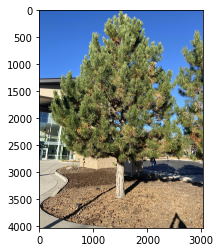

In [ ]:
path = '/content/drive/MyDrive/CE315_Fall_2021/PlantImages/Test'
i=0
for img in os.listdir(path):
  i+=1
  img_array = cv2.imread(os.path.join(path,img))
  if (i == 2):
    break

plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
img_array = cv2.resize(img_array, (224,224)) 
img_array = img_array.reshape(-1,224,224,3)

predictions = model.predict([img_array])
print("Prediction Value: ", predictions)
for prediction in range(0,4):  
  if(int(np.round(predictions[0][prediction]))==1):
      print(CATEGORIES[prediction])

# **Transfer Model Definitions**

**SGD Optimization**

In [ ]:
# MobileNet V2 Transfer Training using ADAM - Requires 224 x 224 img size
# Model definition and initial save in this cell
MobileNetV2_Feature_Extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" 
                                 # Only feature extractor layers, excluding the output layer
MobileNetV2 = hub.KerasLayer(
    MobileNetV2_Feature_Extractor, input_shape=(224, 224, 3), trainable = True) # input_shape optional


model = Sequential([MobileNetV2]) # Defining model as MobileNet_v2


# Output Layer
model.add(Dense(6, activation = tf.nn.softmax)) # 6 output layers for the 6 categories we have so far

opt = SGD(learning_rate = 0.01) # Setting optimizer as ADAM and defining custom learning rate
model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
                  # sparse_categroical_crossentropy to accomodate our categories and pickle shape

model.save('/content/drive/MyDrive/CE315_Fall_2021/Models/MobileNetV2_SGD_Trees_2021.model') # Initial Save

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CE315_Fall_2021/Models/MobileNetV2_SGD_Trees_2021.model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CE315_Fall_2021/Models/MobileNetV2_SGD_Trees_2021.model/assets


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;

**Adam Optimization**

In [ ]:
# MobileNet V2 Transfer Training using ADAM - Requires 224 x 224 img size
# Model definition and initial save in this cell
MobileNetV2_Feature_Extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" 
                                 # Only feature extractor layers, excluding the output layer
MobileNetV2 = hub.KerasLayer(
    MobileNetV2_Feature_Extractor, input_shape=(224, 224, 3), trainable = True) # input_shape optional


model = Sequential([MobileNetV2]) # Defining model as MobileNet_v2


# Output Layer
model.add(Dense(4, activation = tf.nn.softmax)) # 4 output layers for the 4 categories we have so far

opt = Adam(learning_rate = 0.01) # Setting optimizer as ADAM and defining custom learning rate
model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
                  # sparse_categroical_crossentropy to accomodate our categories and pickle shape

model.save('/content/drive/MyDrive/CE315_Fall_2021/Models/MobileNetV2_ADAM_Trees_2021.model') # Initial Save

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CE315_Fall_2021/Models/MobileNetV2_ADAM_Trees_2021.model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CE315_Fall_2021/Models/MobileNetV2_ADAM_Trees_2021.model/assets
